In [1]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

## Load data

In [2]:
G = nx.read_edgelist('coauthorship.edgelist', delimiter=' ', nodetype=int)

## Find the number of co-authors

In [3]:
nodes = G.nodes
nb_of_neigbours = np.zeros(G.number_of_nodes())
i = 0

for node in nodes:
    neighbors = list(G.neighbors(node))
    nb_of_neigbours[i] = len(neighbors)
    i += 1

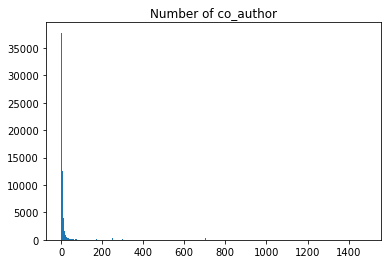

In [4]:
plt.title("Number of co_author")
plt.hist(nb_of_neigbours, bins = int(max(nb_of_neigbours)))
plt.show()

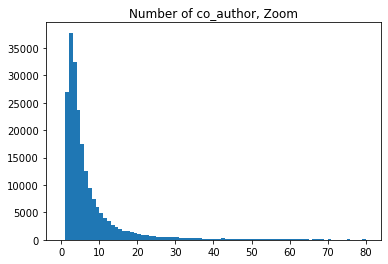

In [5]:
plt.title("Number of co_author, Zoom")
plt.hist(nb_of_neigbours, bins = 80, range = [0,80])
plt.show()

## Number of words in the abstracts

In [10]:
import numpy as np
import nltk
from nltk.corpus import stopwords

linecount = open('abstracts.txt', encoding = "utf-8")
line = sum(1 for _ in linecount)
file = open('abstracts.txt', encoding='utf8')
stopwords_ = set(stopwords.words('english'))

nb_of_words = np.zeros(line)
nb_of_usefull_words = np.zeros(line)

Absdict = {}
for i in tqdm(range(line)):
    newLine = file.readline()
    split = newLine.split('----', 1)
    Dict = eval(split[1])  
    nb_of_words[i] = Dict['IndexLength']

    newDict = {}
    for key, value in Dict['InvertedIndex'].items():
        if key.lower() not in stopwords_:
            for new_key in value:
                newDict[new_key] = key
    nb_of_usefull_words[i] = len(newDict)

100%|█████████████████████████████████████████████████████████████████████████| 624181/624181 [13:46<00:00, 755.56it/s]


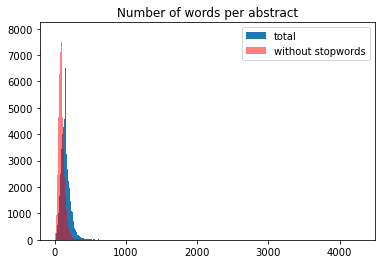

In [11]:
plt.title("Number of words per abstract")
plt.hist(nb_of_words, bins = int(max(nb_of_words)), label = 'total')
plt.hist(nb_of_usefull_words, bins = int(max(nb_of_usefull_words)), color = 'r', alpha = 0.5, label = 'without stopwords')
plt.legend(loc = 'best')
plt.show()

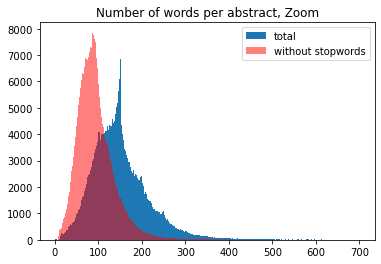

In [12]:
plt.title("Number of words per abstract, Zoom")
plt.hist(nb_of_words, bins = 700, label = 'total', range = [0,700])
plt.hist(nb_of_usefull_words, bins = 700, color = 'r', alpha = 0.5, label = 'without stopwords', range = [0,700])
plt.legend(loc ='best')
plt.show()

## Repartition of the absolute error

In [14]:
df_train = pd.read_csv('train.csv', dtype={'author': np.int64, 'hindex': np.float32})
df_test = pd.read_csv('test.csv', dtype={'author': np.int64})
x_train_complete = pd.read_csv('X_train.csv')
y_train_complete = pd.read_csv('y_train.csv')
x_test_complete = pd.read_csv('X_test.csv')

x_train,x_val,y_train,y_val = train_test_split(x_train_complete,y_train_complete)
x_train = x_train.to_numpy()
x_val = x_val.to_numpy()
y_train = y_train.to_numpy().ravel()
y_val = y_val.to_numpy().ravel()
x_train = np.nan_to_num(x_train)
x_val = np.nan_to_num(x_val)

In [15]:
from lightgbm import LGBMRegressor
reg = LGBMRegressor(objective='mse',
                    boosting_type='dart',
                    colsample_bytree=1,
                    learning_rate=0.05,
                    max_depth=10,
                    n_estimators=3000,
                    num_leaves=32,
                    reg_alpha=0.5,
                    reg_lambda=1,
                    subsample=0.5,
                    n_jobs=12,
                     verbose=0)
reg.fit(x_train, y_train)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.370821 seconds.
You can set `force_col_wise=true` to remove the overhead.


LGBMRegressor(boosting_type='dart', colsample_bytree=1, learning_rate=0.05,
              max_depth=10, n_estimators=3000, n_jobs=12, num_leaves=32,
              objective='mse', reg_alpha=0.5, reg_lambda=1, subsample=0.5,
              verbose=0)

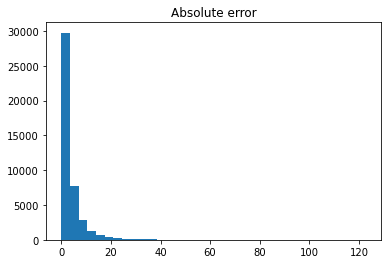

In [19]:
y_pred = reg.predict(x_val)

plt.title("Absolute error")
plt.hist(np.abs(y_pred - y_val), bins = int((len(y_pred)**(1/3))))
plt.show()

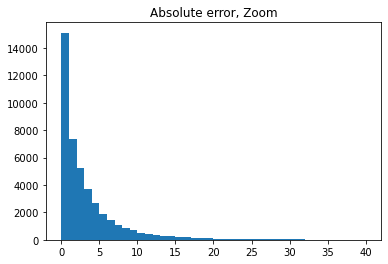

In [20]:
plt.title("Absolute error, Zoom")
plt.hist(np.abs(y_pred - y_val), bins = 40, range = [0,40])
plt.show()